# Big Data in Finance: Part II <BR><BR> Lecture 4: Merge CRSP and Compustat 
   
**Instructor** <BR>
Ritt Keerati, ritt.keerati@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu <BR>


<sub> Credit: lecture notes originally developed by Lira Mota

## Plan for Today:

* Query CRSP/Compustat merged table (annual or quarterly)

    1. Output table is CRSP-centric with permno-datadate being the primary key
    2. Fiscal period end date must be within link date range
    3. WRDS SAS code can be found [here](https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-sas/sas-from-your-computer/)

* Create a final data set called "stock_annual" that has both crsp (permno/permco) and compustat (gvkey) identifiers

**Set Up**

In [1]:
%matplotlib inline 

# Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
db = wrds.Connection(wrds_username='rkeerati')  # make sure to configure wrds connector beforehand

Loading library list...
Done


In [3]:
# Load Compustat and CRSP data. Data downloaded in lecture notes 2 and 3.
compa = pd.read_pickle('/Users/rk2941/Dropbox/courses/big_data_2022/lecture_outputs/compa_annual.pkl')
crspm = pd.read_pickle('/Users/rk2941/Dropbox/courses/big_data_2022/lecture_outputs/crsp_montly.pkl')

## What is the difficulty with merging CRSP and Compustat?

### Possibility: CUSIP

A CUSIP is a nine-digit numeric (e.g. 037833100 for Apple) or nine-character alphanumeric (e.g. 38259P508 for Google) code that identifies a North American financial security for the purposes of facilitating clearing and settlement of trades. The CUSIP was adopted as an American National Standard under Accredited Standards X9.6. The acronym, pronounced as "kyoo-sip," derives from Committee on Uniform Security Identification Procedures.

The CUSIP system is owned by the American Bankers Association and is operated by S&P Global Market Intelligence. The operating body, CUSIP Global Services (CGS), also serves as the national numbering agency (NNA) for North America, and the CUSIP serves as the National Securities Identification Number (NSIN) for products issued from both the United States and Canada. 

Source: Wikipedia 


In [4]:
compa[['gvkey', 'datadate', 'fyear', 'conm', 'tic', 'cusip']][compa.tic=='T']

,gvkey,datadate,fyear,conm,tic,cusip
105134,009899,1984-12-31,1984.0,AT&T INC,T,00206R102
105137,009899,1985-12-31,1985.0,AT&T INC,T,00206R102
105144,009899,1986-12-31,1986.0,AT&T INC,T,00206R102
105145,009899,1987-12-31,1987.0,AT&T INC,T,00206R102
105146,009899,1988-12-31,1988.0,AT&T INC,T,00206R102
105147,009899,1989-12-31,1989.0,AT&T INC,T,00206R102
105148,009899,1990-12-31,1990.0,AT&T INC,T,00206R102
105149,009899,1991-12-31,1991.0,AT&T INC,T,00206R102
105150,009899,1992-12-31,1992.0,AT&T INC,T,00206R102
105151,009899,1993-12-31,1993.0,AT&T INC,T,00206R102


**What's the problem with this?**

In [5]:
crspm.columns

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'comnam', 'dlret', 'dlretx', 'exchcd', 'naics', 'cusip',
       'ncusip', 'shrcd', 'shrout', 'siccd', 'ticker', 'retadj', 'me', 'mesum',
       'melag_nt', 'melag', 'rankyear', 'mdate', 'rf'],
      dtype='object')

### Possibility: Names or Ticker 

In [6]:
crspm_t = crspm[['permno','permco','date', 'comnam', 'ticker', 'cusip', 'ncusip', 'retadj']][crspm.ticker=='T']

In [7]:
crspm_t.comnam.unique()

array(['AMERICAN TELEPHONE & TELEG CO', 'A T & T CORP', 'A T & T INC'],
      dtype=object)

In [8]:
crspm_t[crspm_t.comnam=='AMERICAN TELEPHONE & TELEG CO'].sort_values('date')

,permno,permco,date,comnam,ticker,cusip,ncusip,retadj
2854963,10401,20103.0,1980-02-29,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,0.002481
2860015,10401,20103.0,1980-03-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,-0.012690
2865069,10401,20103.0,1980-04-30,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,0.082262
2870128,10401,20103.0,1980-05-30,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,0.038005
2875198,10401,20103.0,1980-06-30,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,-0.016393
...,...,...,...,...,...,...,...,...
672865,10401,20103.0,1993-11-30,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,-0.050000
680801,10401,20103.0,1993-12-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,-0.032860
688790,10401,20103.0,1994-01-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,0.080952
696824,10401,20103.0,1994-02-28,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,-0.074890


In [9]:
crspm_t[crspm_t.comnam=='A T & T CORP'].sort_values('date')

,permno,permco,date,comnam,ticker,cusip,ncusip,retadj
713077,10401,20103.0,1994-04-29,A T & T CORP,T,00195750,00195710,0.000000
721299,10401,20103.0,1994-05-31,A T & T CORP,T,00195750,00195710,0.065854
729573,10401,20103.0,1994-06-30,A T & T CORP,T,00195750,00195710,0.001465
737871,10401,20103.0,1994-07-29,A T & T CORP,T,00195750,00195710,0.004598
746200,10401,20103.0,1994-08-31,A T & T CORP,T,00195750,00195710,0.000000
...,...,...,...,...,...,...,...,...
1824636,10401,20103.0,2005-07-29,A T & T CORP,T,00195750,00195750,0.052390
1831634,10401,20103.0,2005-08-31,A T & T CORP,T,00195750,00195750,-0.006061
1838616,10401,20103.0,2005-09-30,A T & T CORP,T,00195750,00195750,0.006098
1845595,10401,20103.0,2005-10-31,A T & T CORP,T,00195750,00195750,0.010985


In [10]:
crspm_t[crspm_t.comnam=='A T & T INC'].sort_values('date')

,permno,permco,date,comnam,ticker,cusip,ncusip,retadj
1860942,66093,21645.0,2005-12-30,A T & T INC,T,00206R10,00206R10,-0.016861
1867902,66093,21645.0,2006-01-31,A T & T INC,T,00206R10,00206R10,0.073193
1874846,66093,21645.0,2006-02-28,A T & T INC,T,00206R10,00206R10,0.063198
1881782,66093,21645.0,2006-03-31,A T & T INC,T,00206R10,00206R10,-0.019935
1888714,66093,21645.0,2006-04-28,A T & T INC,T,00206R10,00206R10,-0.018399
...,...,...,...,...,...,...,...,...
3638744,66093,21645.0,2021-08-31,A T & T INC,T,00206R10,00206R10,-0.022460
3647905,66093,21645.0,2021-09-30,A T & T INC,T,00206R10,00206R10,-0.014953
3657168,66093,21645.0,2021-10-29,A T & T INC,T,00206R10,00206R10,-0.045539
3666536,66093,21645.0,2021-11-30,A T & T INC,T,00206R10,00206R10,-0.096200


### Possibility: Linking Tables

In [11]:
crsp_tables = db.list_tables(library="crsp") 
crsp_tables = pd.DataFrame({'tables':crsp_tables}) # Transform libs to a Pandas data frame to have a better display.
crsp_tables[crsp_tables.tables.str.contains('ccm')]

,tables
19,ccm_lookup
20,ccm_qvards
21,ccmxpf_linktable
22,ccmxpf_lnkhist
23,ccmxpf_lnkrng
24,ccmxpf_lnkused


**CCMXPF_LNKHIST - Link History**


* CCMXPF_LNKHIST contains the historical and current links between GVKEY and LPERMNO/LPERMCO (previously known as NPERMN O/NPERMCO in old version CCM). 


* In addition, it includes the beginning and ending dates for links, the link types, and the primary issue marker, and liid codes (Compustat's secondary ID variable, IID).

[Source](https://wrds-www.wharton.upenn.edu/pages/support/research-wrds/research-guides/ccm-sas-datasets/)

In [12]:
db.describe_table(library="crsp", table="ccmxpf_lnkhist")

Approximately 110923 rows in crsp.ccmxpf_lnkhist.


,name,nullable,type
0,gvkey,True,VARCHAR(6)
1,linkprim,True,VARCHAR(1)
2,liid,True,VARCHAR(3)
3,linktype,True,VARCHAR(2)
4,lpermno,True,DOUBLE_PRECISION
5,lpermco,True,DOUBLE_PRECISION
6,linkdt,True,DATE
7,linkenddt,True,DATE


* LINKPRIM: Primary issue marker for the link.

**Download Data**

In [13]:
sql = '''SELECT gvkey, lpermno as permno, lpermco as permco, linktype, linkdt, linkenddt
         FROM crsp.ccmxpf_lnkhist
         WHERE linktype IN ('LC', 'LU', 'LS') 
      ''' 

link_table = db.raw_sql(sql, date_cols=['linkdt', 'linkenddt'])

## Understading Linking Table

In [14]:
# Example 
link_table[link_table.permco==21645]

,gvkey,permno,permco,linktype,linkdt,linkenddt
9005,009899,66093.0,21645.0,LC,1984-02-16,NaT


In [15]:
# Example: LIBERTY MEDIA
link_table[link_table.permco==54311]

,gvkey,permno,permco,linktype,linkdt,linkenddt
14743,017010,13757.0,54311.0,LC,2013-01-14,2016-04-17
14744,017010,13758.0,54311.0,LC,2013-01-14,2016-04-17
14745,017010,14811.0,54311.0,LC,2014-07-24,2016-04-17
14746,017010,15998.0,54311.0,LC,2016-04-18,2017-12-31
14747,017010,15998.0,54311.0,LC,2018-01-01,NaT
14748,017010,15999.0,54311.0,LC,2016-04-18,NaT
14749,017010,16000.0,54311.0,LC,2016-04-18,2017-12-31
14750,017010,16000.0,54311.0,LC,2018-01-01,NaT
19284,027186,15996.0,54311.0,LC,2016-04-18,2017-12-31
19285,027186,15996.0,54311.0,LC,2018-01-01,NaT


## Merge and Link

* Link type code. Each link is given a code describing the connection between the CRSP and Compustat data. 

* Values are:

    * LC – Link research complete. Standard connection between databases.
    * LU – Unresearched link to issue by CUSIP
    * LS – Link valid for this security only. Other CRSP PERMNOs with the same PERMCO will link to other GVKEYs.
    * LX – Link to a security that trades on another exchange system not included in CRSP data.
    * LD – Duplicate Link to a security. Another GVKEY/IID is a better link to that CRSP record.
    * LN – Primary link exists but Compustat does not have prices.
    * NR – No link available, confirmed by research
    * NU – No link available, not yet confirmed

In [16]:
link_table.linktype.value_counts()

LC    16246
LU    16032
LS     4127
Name: linktype, dtype: int64

In [17]:
compa.head()

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,ps,dt,be,cost,op,opbe,at_lag,inv,fdiff,inv_capx
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983.0,12.0,14.080,3.367,7.823,...,0.0,0.000,7.823,23.508,1.887,0.241212,NaN,NaN,1.0,NaN
4,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984.0,12.0,16.267,5.496,8.962,...,0.0,0.357,9.319,29.460,2.547,0.273313,14.08,0.155327,1.0,0.390341


In [18]:
df = pd.merge(compa, link_table, on=['gvkey'], how='inner') 

In [19]:
df

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,opbe,at_lag,inv,fdiff,inv_capx,permno,permco,linktype,linkdt,linkenddt
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
3,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983.0,12.0,14.080,3.367,7.823,...,0.241212,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
4,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984.0,12.0,16.267,5.496,8.962,...,0.273313,14.080,0.155327,1.0,0.390341,10015.0,6398.0,LU,1983-09-20,1986-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436850,345980,2019-12-31,CONTEXTLOGIC INC,WISH,21077C107,2019.0,12.0,1366.000,11.000,-1439.000,...,NaN,1193.000,0.145013,1.0,0.009220,20333.0,57666.0,LC,2020-12-16,NaT
436851,345980,2020-12-31,CONTEXTLOGIC INC,WISH,21077C107,2020.0,12.0,2397.000,2.000,1027.000,...,-0.602726,1366.000,0.754758,1.0,0.001464,20333.0,57666.0,LC,2020-12-16,NaT
436852,347085,2019-02-28,KAROOOOO LTD,KARO,Y4600W108,2018.0,2.0,108.754,30.018,43.983,...,1.206125,NaN,NaN,NaN,NaN,21069.0,58208.0,LC,2021-04-01,NaT
436853,347085,2020-02-29,KAROOOOO LTD,KARO,Y4600W108,2019.0,2.0,117.551,24.763,55.947,...,1.096377,108.754,0.080889,1.0,0.227697,21069.0,58208.0,LC,2021-04-01,NaT


In [20]:
# Keep only linking with the right range
df = df[(df.datadate >= df.linkdt) | (df.linkdt.isnull())]
df = df[(df.datadate <= df.linkenddt) | (df.linkenddt.isnull())]

In [21]:
df['permno'] = df['permno'].astype(int)
df['permco'] = df['permco'].astype(int)
df['datadate'] = pd.to_datetime(df['datadate'])

In [22]:
df.shape

(285025, 55)

In [23]:
compa.shape

(441833, 50)

In [24]:
# Should we have duplicated entries for (permco, datadate)?
df.duplicated(subset=['permco', 'datadate']).sum()

23485

In [25]:
# Yes! one companies with multiple securities

<AxesSubplot:xlabel='fyear'>

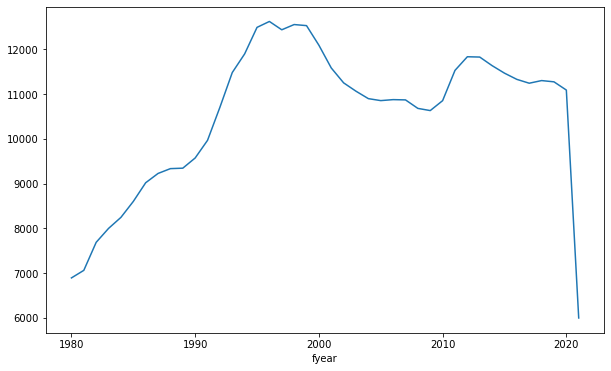

In [26]:
# Number of companies have declined since late 1990s
compa.groupby(['fyear']).gvkey.nunique().plot()

<AxesSubplot:xlabel='fyear'>

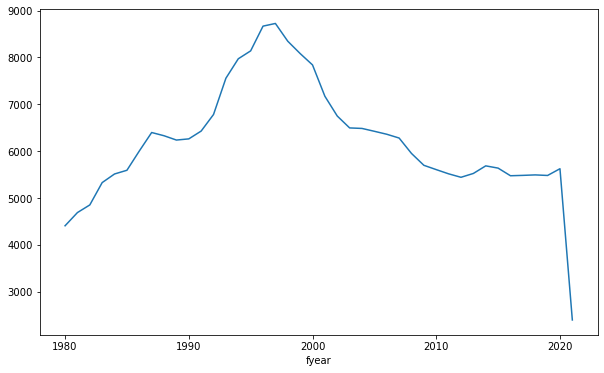

In [27]:
# So does the number of traded stocks
df.groupby(['fyear']).permco.nunique().plot()

* Why do we see a decline in the number of publicly listed stocks?
* Take a look at [Doidge, Karolyi, Stulz (2017)](https://www.sciencedirect.com/science/article/pii/S0304405X1630232X)

## Special Cases

In [28]:
df.groupby(['permno','datadate']).gvkey.nunique().max()

1

### Many PERMCOs for One GVKEY

In [29]:
df.groupby('gvkey').permco.nunique().max()

4

In [30]:
df.loc[df.gvkey==df.groupby('gvkey').permco.nunique().idxmax(), ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']]

,datadate,permno,permco,gvkey,conm,at
309549,1995-12-31,81875,4388,032280,STARZ,2517.636
309556,1996-12-31,81875,4388,032280,STARZ,3058.952
309563,1997-12-31,81875,4388,032280,STARZ,5038.561
309570,1998-12-31,81875,4388,032280,STARZ,20348.000
309578,1999-12-31,86746,20103,032280,STARZ,58684.000
309585,2000-12-31,86746,20103,032280,STARZ,54268.000
309593,2001-12-31,89130,41998,032280,STARZ,48539.000
309600,2002-12-31,89130,41998,032280,STARZ,39685.000
309607,2003-12-31,89130,41998,032280,STARZ,54013.000
309614,2004-12-31,89130,41998,032280,STARZ,50181.000


### Many GVKEYs for one PERMCO

In [31]:
df[df['at'].notnull()].groupby('permco').gvkey.nunique().max()

5

In [32]:
df.loc[df.permco==df[df['at'].notnull()].groupby('permco').gvkey.nunique().idxmax(), ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
364615,1994-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
364616,1995-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
165364,1996-12-31,10324,8243,012233,GENZYME CORP,1229.519
364617,1996-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,42.593
165365,1997-12-31,10324,8243,012233,GENZYME CORP,1203.056
364618,1997-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,56.818
363660,1998-12-31,86426,8243,117298,GENZYME MOLECULAR ONCOLOGY,35.952
364619,1998-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,18.954
165366,1998-12-31,10324,8243,012233,GENZYME CORP,1646.307
364620,1999-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,19.648


### Many GVKEYs for one PERMCO for the Same Date

In [33]:
df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().max()

4

In [34]:
df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().idxmax()

(8243, Timestamp('1999-12-31 00:00:00'))

In [35]:
df.loc[df.permco==8243, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
364615,1994-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
364616,1995-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
165364,1996-12-31,10324,8243,012233,GENZYME CORP,1229.519
364617,1996-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,42.593
165365,1997-12-31,10324,8243,012233,GENZYME CORP,1203.056
364618,1997-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,56.818
363660,1998-12-31,86426,8243,117298,GENZYME MOLECULAR ONCOLOGY,35.952
364619,1998-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,18.954
165366,1998-12-31,10324,8243,012233,GENZYME CORP,1646.307
364620,1999-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,19.648


In [36]:
df.loc[df.permco==54311, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
220288,2013-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,34542.0
220289,2013-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,34542.0
220296,2014-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
220297,2014-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
220298,2014-12-31,14811,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
220304,2015-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
220305,2015-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
220306,2015-12-31,14811,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
274965,2016-12-31,15997,54311,027186,LIBERTY MEDIA BRAVES GROUP,1548.0
274991,2016-12-31,13757,54311,027187,LIBERTY MEDIA FORMULA ONE,2995.0
